In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import pymc as pm
import pytensor
import pytensor.tensor as pt
import arviz as az

import sys
sys.path.append('..')
from ukraine_sentiment.graphing import config_matplotlib
config_matplotlib()

# Model Setup

Consider a fully-connected network -- regions in a country. Information travels instantaneously through the network according to edge weights, given in an attention matrix $A$, with elements: $a_{i,j} \in [0, 1]$ and $a_{i,i} = 1$. That is, regions always pay attention to themselves, and pay attention to other regions with some scaling factor.

The country is at war, and attacks occur at nodes in the network. These attacks cause fear throughout the network. Call the impact on fear of an attack $\epsilon_t$. The effect on any location in the network will be $R\epsilon_t$, because information about the attack travels instantly. Fear will increase all throughout the network, but unevenly, since not all nodes pay the same amount of attention to the attacked node.

Attacks do not occur every period. Define an indicator variable $\varphi_t$ that takes a value of 1 if an attack occurs, and 0 otherwise.

Assume that the fear signal is imperfectly observed, so that there is also some i.i.d white noise, $\eta_t$. 

Finally, assume that fear within a region lingers for some time, independently of any other region. The degree of lingering will be $\Gamma$, with $\gamma_{i,i} \in [0, 1)$ and $\gamma_{i,j} = 0$.

$$x_{t+1} = \Gamma x_t + \varphi_tR\epsilon_t + \eta_t$$

with
$$\begin{align} \epsilon_t & \sim N(0, Q) \\
                    \eta_t & \sim N(0, \Sigma) \end{align}$$
                    
The attention matrix $R$ can be brought into the covariance of $\epsilon$; define $nu_t \sim N(0, RQR^T)$, then:

$$x_{t+1} = \Gamma x_t + \varphi_t \nu_t + \eta_t$$

Also I guess $\Sigma$ should be diagonal.

In [5]:
from scipy.special import expit
n_regions = 2
T = 100

rng = np.random.default_rng(sum(map(ord, 'VAR test')))

true_Γ = np.diag(expit(rng.normal(scale=3, size=n_regions)))
true_R = expit(rng.normal(scale=3, size=((n_regions, n_regions))))
true_R[np.diag_indices_from(true_R)] = 1

true_Σ = np.diag(rng.gamma(2, 1, size=(n_regions)))
true_obs_Σ = np.diag(rng.gamma(2, 1, size=(n_regions)))
true_Q = rng.normal(scale=1, size=(n_regions, n_regions))
true_Q = true_Q @ true_Q.T
true_Q = true_Q / np.linalg.norm(true_Q)

true_intercept = rng.normal(loc=-2, scale=1, size=n_regions)

true_p_attack = rng.uniform(0, 1, size=n_regions)
attack_data = rng.binomial(1, true_p_attack, size=(T, n_regions))

data = np.zeros((T, n_regions, 1))
observed = np.zeros((T, n_regions, 1))

data[0, ...] = rng.normal(loc=-2, scale=2, size=(n_regions, 1))

for t in range(T-1):
#     nu = rng.multivariate_normal(mean=np.zeros(n_regions), cov= true_R @ true_Q @ true_R.T)
#     eta = rng.multivariate_normal(mean=np.zeros(n_regions), cov=true_Σ)
    obs_noise = rng.multivariate_normal(mean=np.zeros(n_regions), cov=true_obs_Σ)
    
    R_attack = np.diag(attack_data[t])    
    assert np.allclose(R_attack @ true_Σ, attack_data[t] * true_Σ)
    
    joint_cov = R_attack @ true_Σ + true_R @ true_Q @ true_R.T
    
    shock = rng.multivariate_normal(mean=np.zeros(n_regions), cov=joint_cov)
    data[t+1] = true_intercept[:, None] + true_Γ @ data[t, None] + shock[:, None]
    observed[t] = data[t] + obs_noise[:, None]
    
fear_index = expit(observed[..., 0]) * 100

In [6]:
from scipy.special import logit
np.allclose(logit(fear_index / 100), observed[..., 0])

True

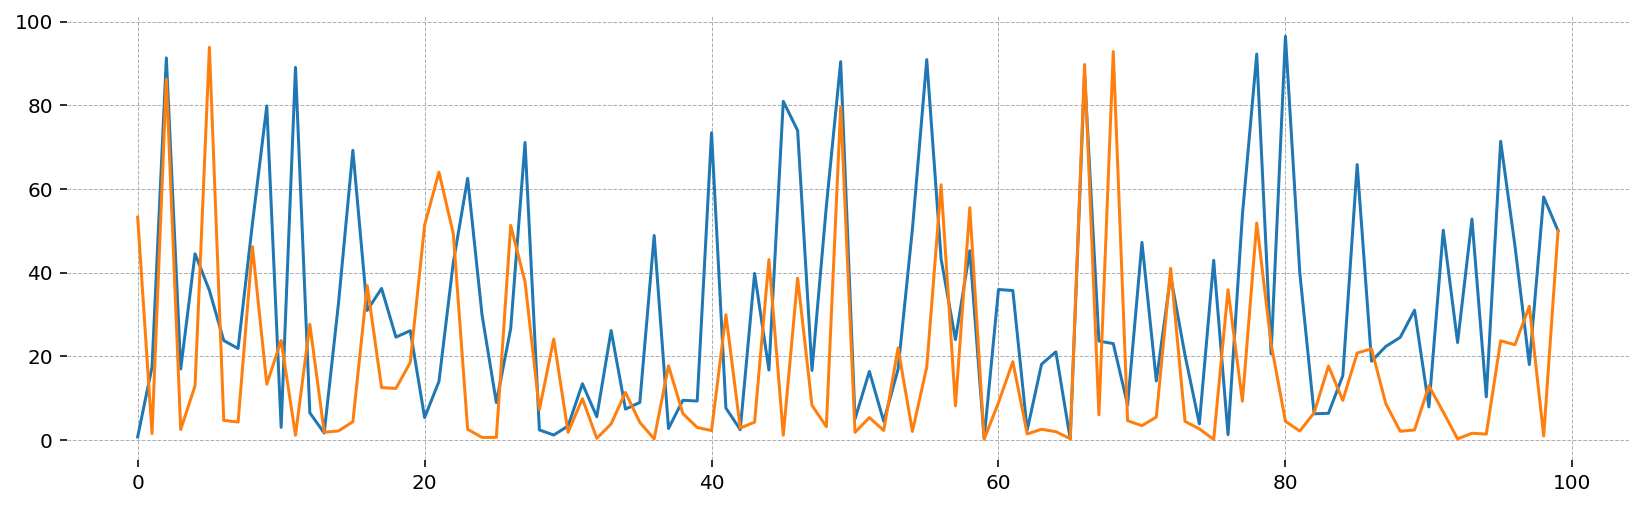

In [7]:
plt.plot(fear_index);

## Parameter Recovery

In [8]:
k = n_regions ** 2 - n_regions

In [66]:
with pm.Model() as model:
    rng = pytensor.shared(np.random.default_rng())
    
    gammas = pm.LogitNormal('gamma', size=n_regions)
    
    r_offdiag = pm.LogitNormal('r_offdiag', mu=-3, sigma=1, size=k)
    
    x0 = pm.Normal('x0', size=n_regions)
    
    R = pt.eye(n_regions)
    R = pt.set_subtensor(R[np.triu_indices(n_regions, 1)], r_offdiag[:k // 2])
    R = pt.set_subtensor(R[np.tril_indices(n_regions, -1)], r_offdiag[k // 2:])
    
    Γ = pt.diag(gammas)
    
    Q_chol, *_ = pm.LKJCholeskyCov('Q_chol', sd_dist=pm.HalfNormal.dist(sigma=3), n=n_regions, eta=10)
    Q = pm.Deterministic('Q', Q_chol @ Q_chol.T)
    
    RQRT = R @ Q @ R.T
    
    sigma_eta = pm.Gamma('sigma_eta', alpha=2, beta=1, size=n_regions)
    Σ = pt.diag(sigma_eta)
        
    def VAR_step(attack, last_x, old_rng, Γ, RQRT, Σ):
        shock_cov = attack * Σ + RQRT
        new_rng, x = pm.MvNormal.dist(mu=Γ @ last_x, cov=shock_cov, rng=old_rng).owner.outputs
        return x, {old_rng:new_rng}
        
    var_mean, updates = pytensor.scan(VAR_step, 
                                      sequences=[pt.as_tensor_variable(attack_data)],
                                      outputs_info=[x0],
                                      non_sequences=[rng, Γ, RQRT, Σ],
                                      strict=True)
    
    model.register_rv(var_mean, name = 'VAR_mean', initval='prior')
    intercept = pm.Normal('intercept', size=n_regions)
    noise_sigmas = pm.Gamma('noise_sigmas', alpha=2, beta=1, size=n_regions)

    obs = pm.Normal('obs', mu = intercept + var_mean, sigma=noise_sigmas, observed=observed[..., 0])
    
    idata = pm.sample(init='jitter+adapt_diag_grad')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma, r_offdiag, x0, Q_chol, sigma_eta, VAR_mean, intercept, noise_sigmas]


Sampling 3 chains for 1_000 tune and 660 draw iterations (3_000 + 1_980 draws total) took 1477 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


<Axes: >

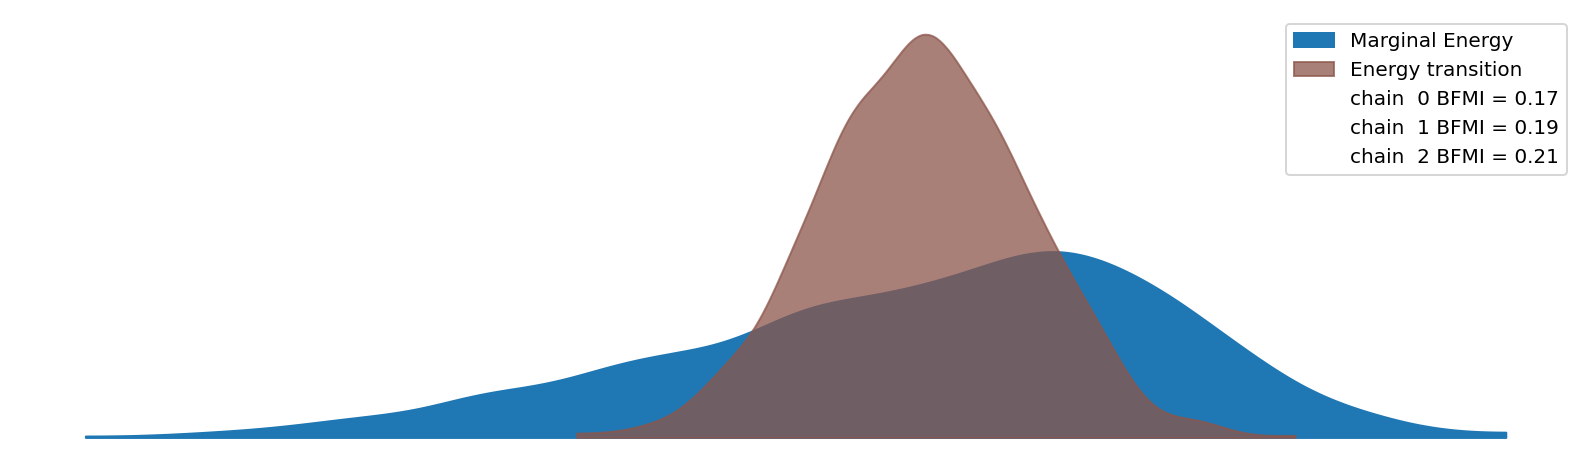

In [67]:
az.plot_energy(idata)

In [ ]:
with model:
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True, compile_kwargs={'updates':updates})

Sampling: [obs]


In [ ]:
with model:
    priors = pm.sample_prior_predictive(samples=1000, compile_kwargs={'updates':updates})

In [ ]:
preds = az.extract(idata, 'posterior_predictive').obs
hdi = az.hdi(idata.posterior_predictive.obs).obs

In [ ]:
fig, ax = plt.subplots(n_regions, 1, figsize=(14, 9))
for i, axis in enumerate(fig.axes):
    axis.plot(preds.values.mean(axis=-1)[:, i])
    axis.fill_between(np.arange(T), *hdi.values[:, i, :].T, alpha=0.25)
    axis.plot(observed[:, i, 0])

In [ ]:
r_values = np.r_[true_R[np.triu_indices(n_regions, 1)], true_R[np.tril_indices(n_regions, -1)]]

array([<Axes: title={'center': 'r_offdiag\n0'}>,
       <Axes: title={'center': 'r_offdiag\n1'}>], dtype=object)

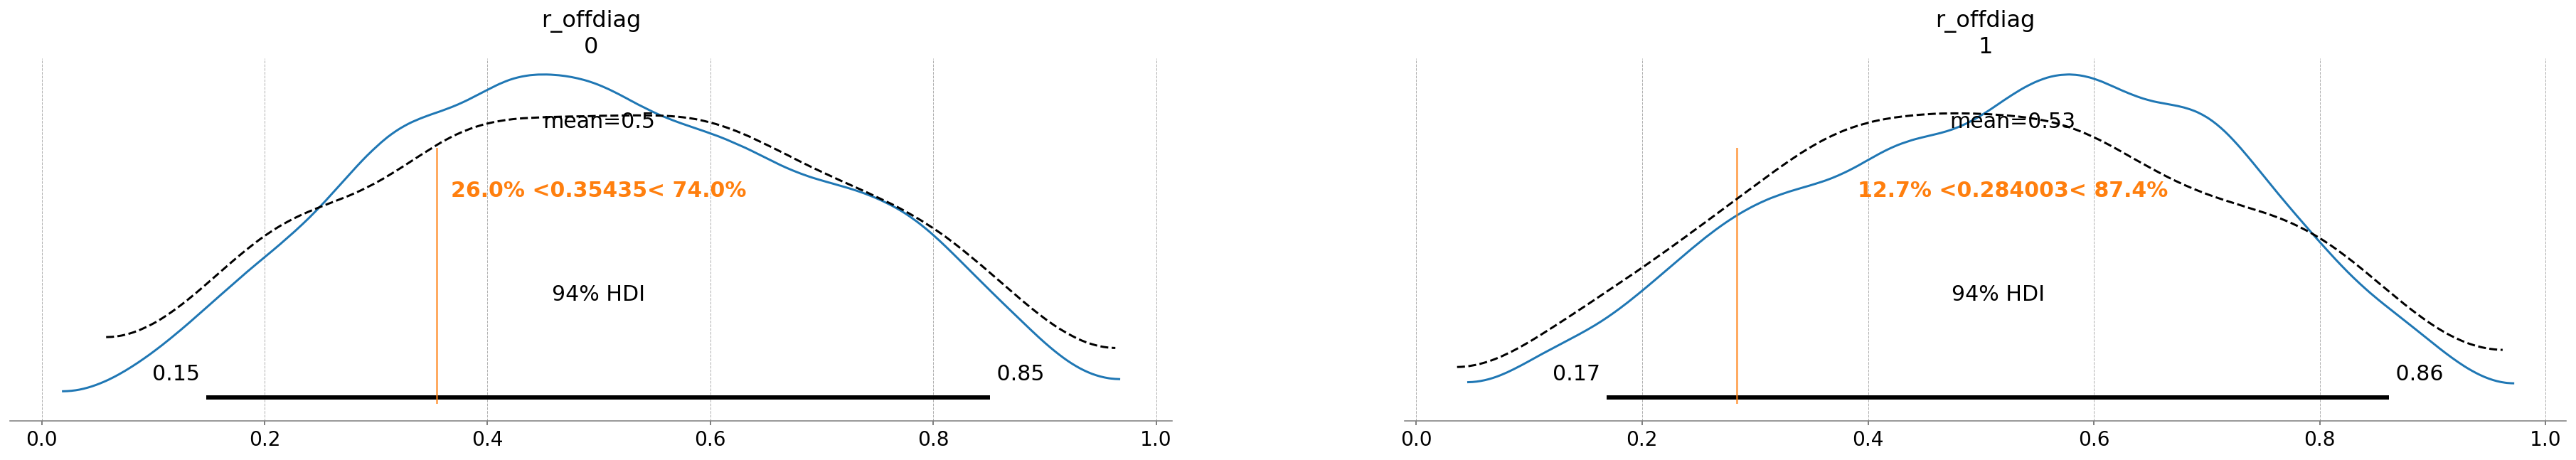

In [53]:
axes = az.plot_posterior(idata, var_names=['r_offdiag'], ref_val=r_values.tolist())
az.plot_posterior(priors, var_names=['r_offdiag'], group='prior', ax=axes, point_estimate=None, hdi_prob='hide', rope_color='none', ls='--', color='k')

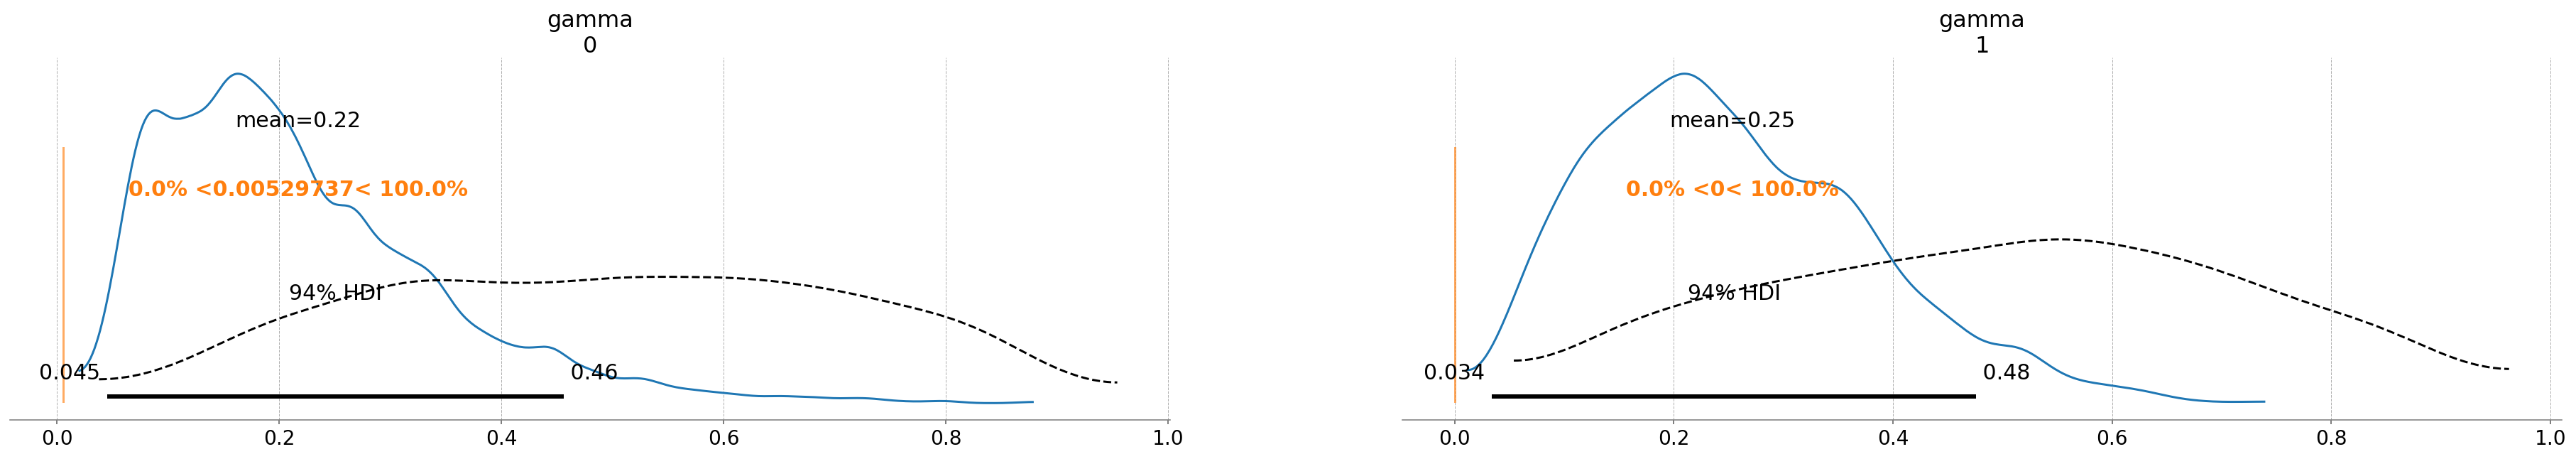

In [55]:
axes = az.plot_posterior(idata, var_names=['gamma'], ref_val=true_Γ.ravel().tolist())
az.plot_posterior(priors, var_names=['gamma'], group='prior', ax=axes, point_estimate=None, hdi_prob='hide', rope_color='none', ls='--', color='k');

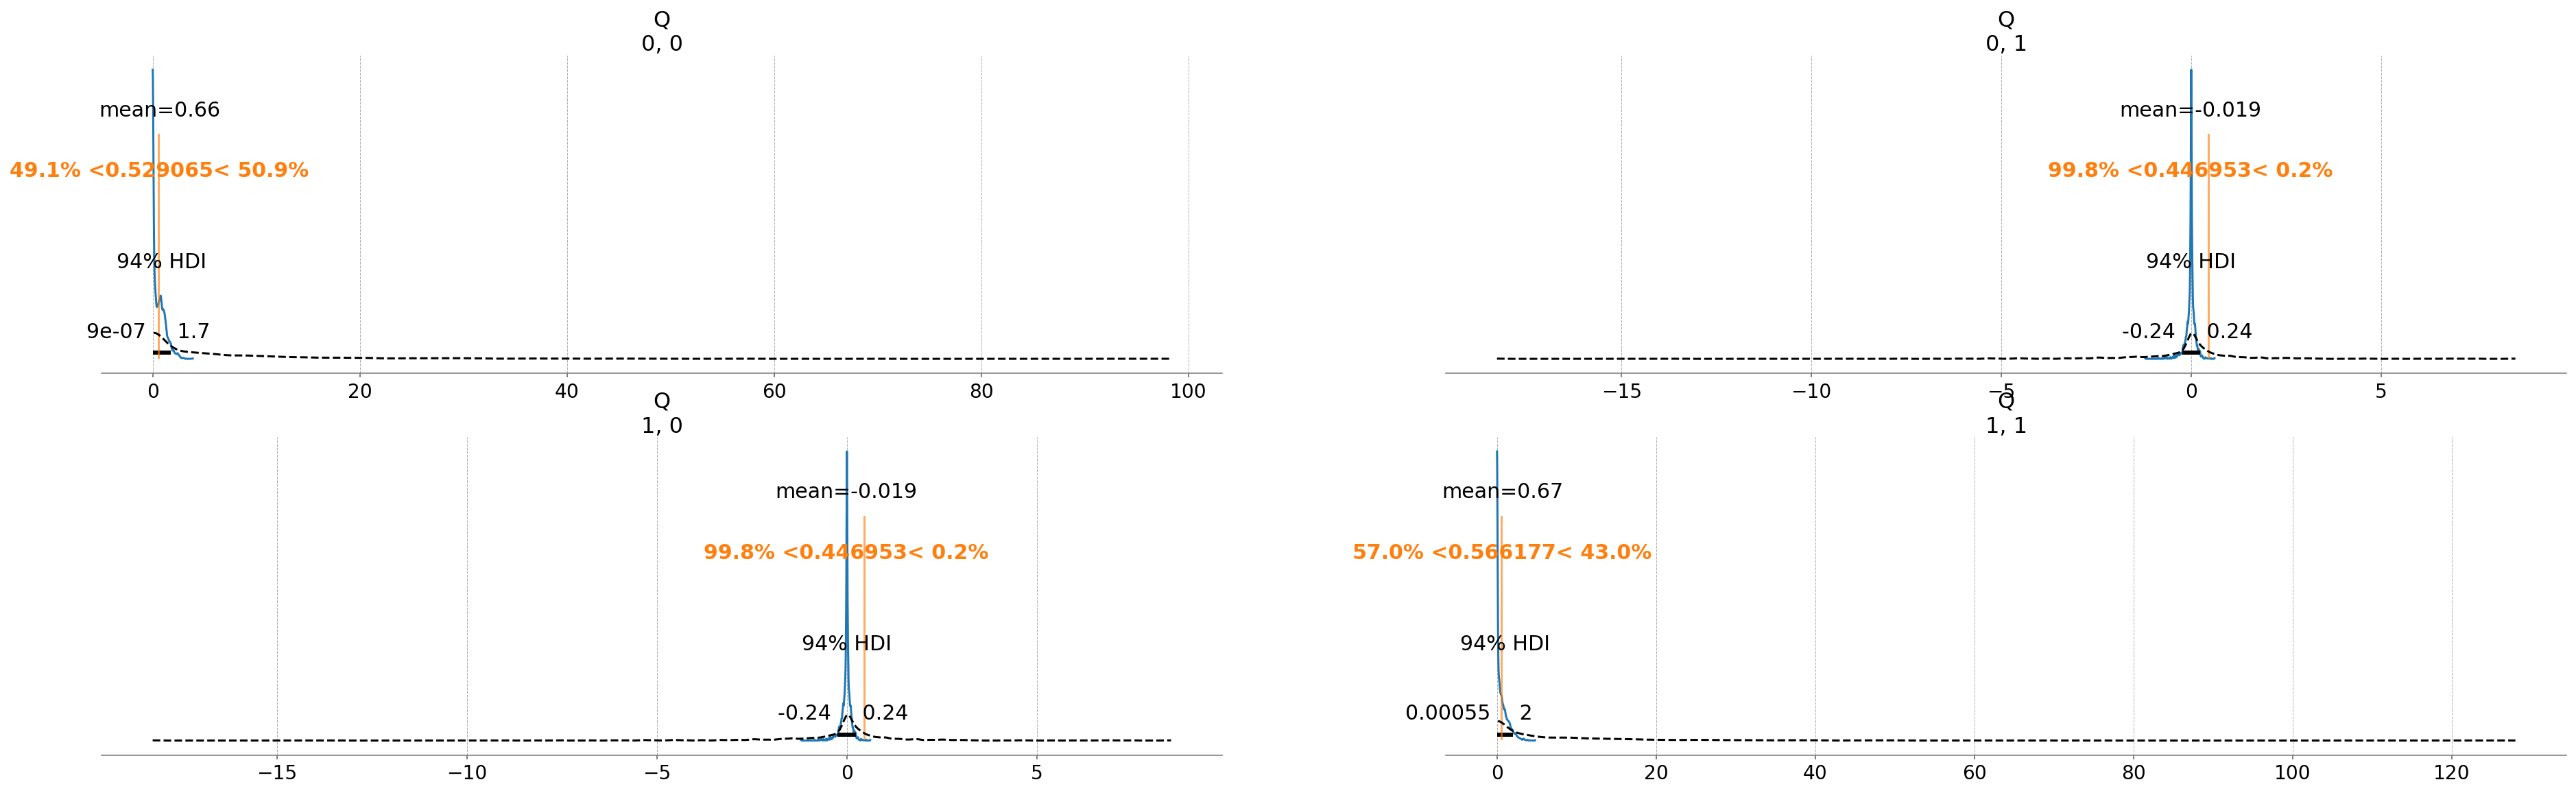

In [61]:
axes = az.plot_posterior(idata, var_names=['Q'], ref_val=true_Q.ravel().tolist(), grid=(2, 2))
az.plot_posterior(priors, var_names=['Q'], group='prior', grid=(2,2), ax=axes, point_estimate=None, hdi_prob='hide', rope_color='none', ls='--', color='k');

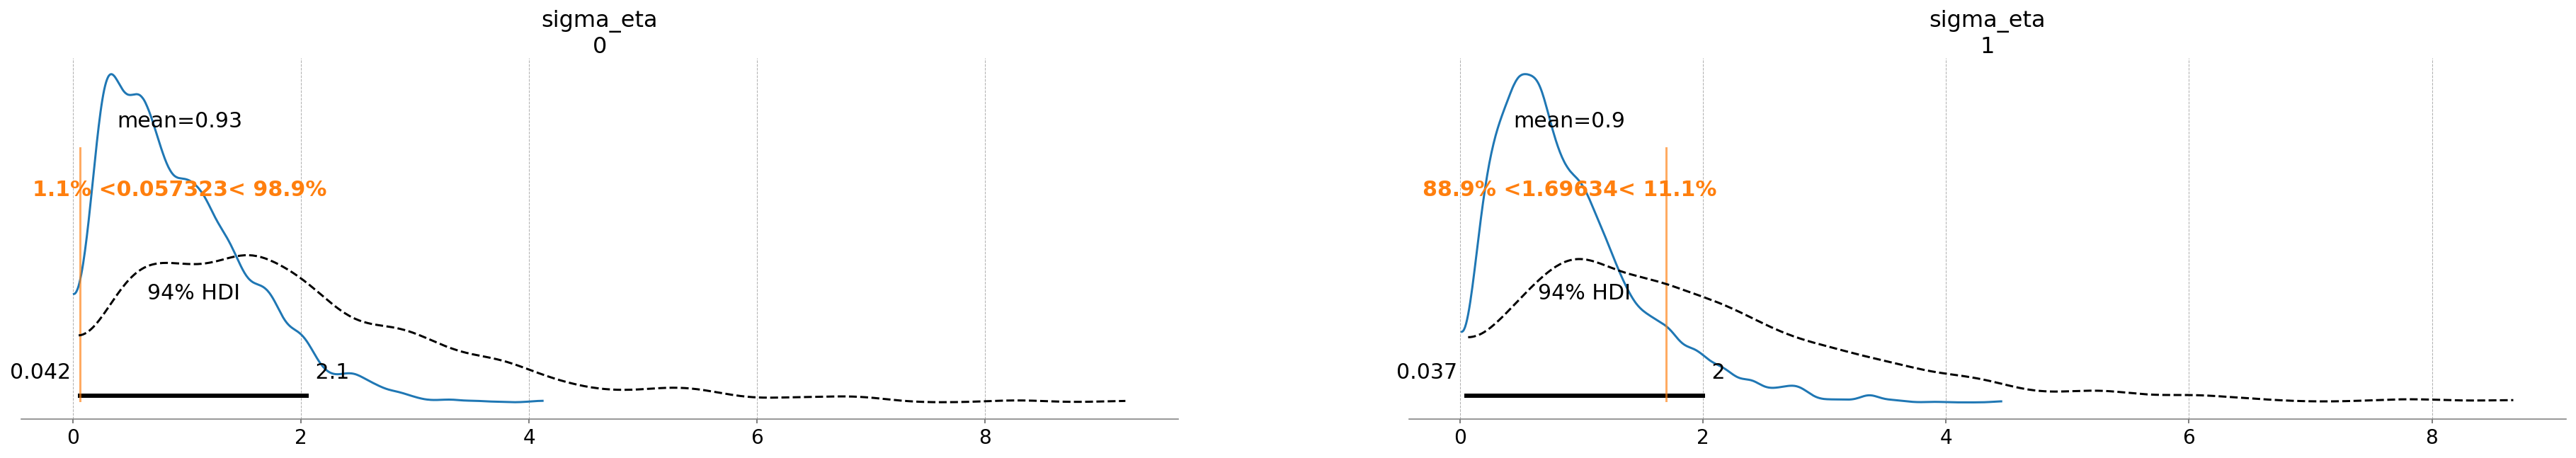

In [64]:
axes = az.plot_posterior(idata, var_names=['sigma_eta'], ref_val=np.diagonal(true_Σ).tolist())
az.plot_posterior(priors, var_names=['sigma_eta'], group='prior', ax=axes, point_estimate=None, hdi_prob='hide', rope_color='none', ls='--', color='k');

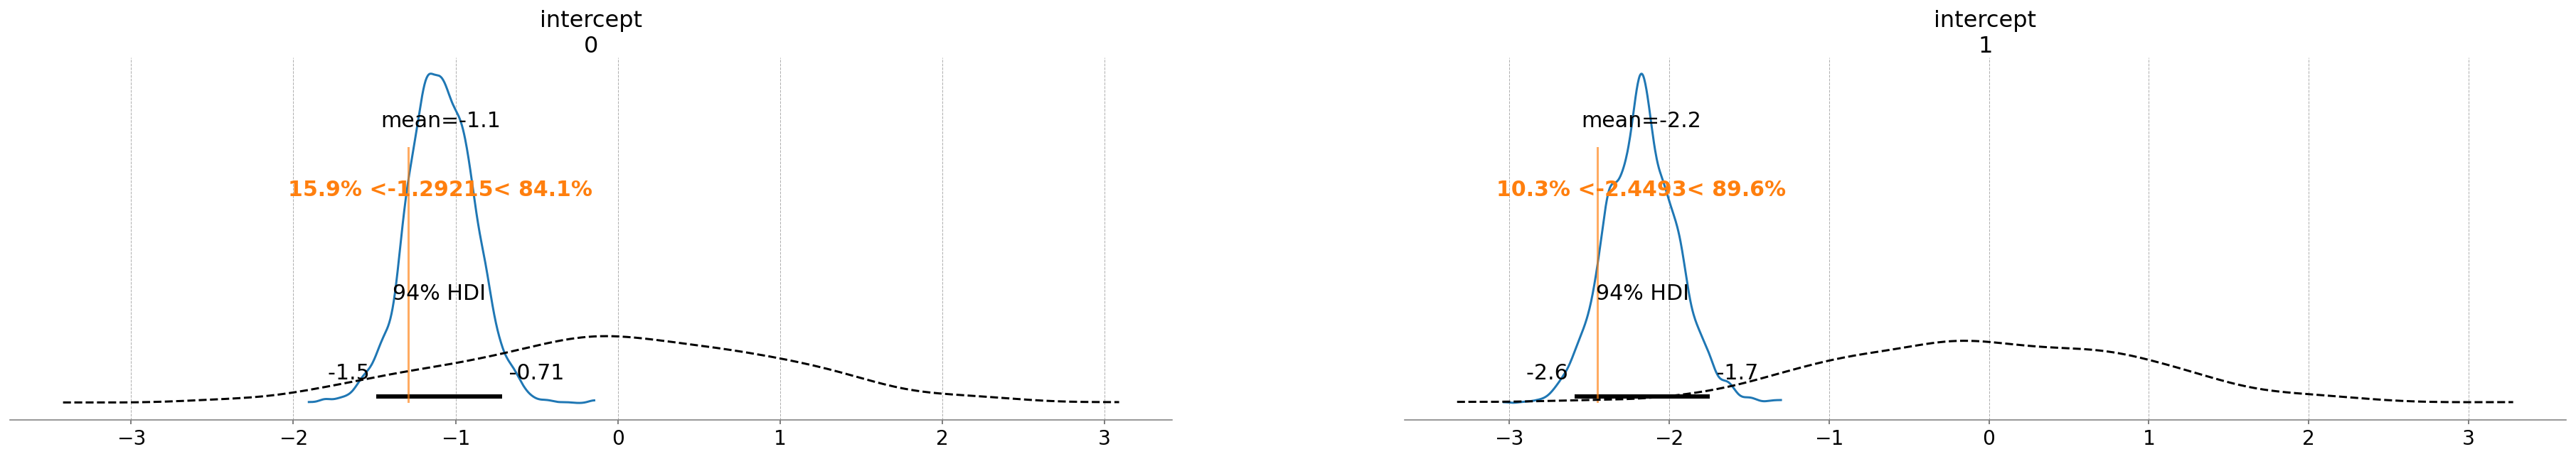

In [65]:
axes = az.plot_posterior(idata, var_names=['intercept'], ref_val=true_intercept.tolist())
az.plot_posterior(priors, var_names=['intercept'], group='prior', ax=axes, point_estimate=None, hdi_prob='hide', rope_color='none', ls='--', color='k');